In [1]:
import cv2, sys
import numpy as np
#
from PIL import Image, ImageDraw
from src.model import preprocessing, postprocessing
# define acllite library path
sys.path.append('../../Common/acllite')
# modules of acllite library
from acllite_model import AclLiteModel
from acllite_resource import AclLiteResource

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# define device id & model path
device_id = 0
model_path = "model/scrfd_34g.om"
# define threshold value & image path
thresh = 0.5
img_path = "../../Common/data/peoples.jpg"

In [4]:
# initialize acllite library
acl_resource = AclLiteResource()
acl_resource.init()
print('[Device] NPU Device id:',acl_resource.device_id)
# load *.om model
model = AclLiteModel(model_path, 0)

init resource stage:
Init resource success
[Device] NPU Device id: 0
Init model resource start...
[AclLiteModel] create model output dataset:
malloc output 0, size 51200
malloc output 1, size 12800
malloc output 2, size 3200
malloc output 3, size 204800
malloc output 4, size 51200
malloc output 5, size 12800
Create model output dataset success
Init model resource success


In [5]:
# read image
img_bgr = cv2.imread(img_path)

In [6]:
# 1) pre-processing stage
prep_img, postprocess, blob, det_scale = preprocessing(img_bgr, model._model_desc, thresh)

model input size 1
input  0
model input dims ({'name': 'input.1', 'dimCount': 4, 'dims': [1, 3, 640, 640]}, 0)
model input datatype 0
model output size 6
output  0
model output dims ({'name': 'Sigmoid_380:0:score_8', 'dimCount': 3, 'dims': [1, 12800, 1]}, 0)
model output datatype 0
output  1
model output dims ({'name': 'Sigmoid_417:0:score_16', 'dimCount': 3, 'dims': [1, 3200, 1]}, 0)
model output datatype 0
output  2
model output dims ({'name': 'Sigmoid_454:0:score_32', 'dimCount': 3, 'dims': [1, 800, 1]}, 0)
model output datatype 0
output  3
model output dims ({'name': 'Reshape_384:0:bbox_8', 'dimCount': 3, 'dims': [1, 12800, 4]}, 0)
model output datatype 0
output  4
model output dims ({'name': 'Reshape_421:0:bbox_16', 'dimCount': 3, 'dims': [1, 3200, 4]}, 0)
model output datatype 0
output  5
model output dims ({'name': 'Reshape_458:0:bbox_32', 'dimCount': 3, 'dims': [1, 800, 4]}, 0)
model output datatype 0
[Model] class Model init resource stage success
[PreProc] image_np_expanded s

In [7]:
%timeit -n 10 -r 3
result_list = model.execute([prep_img,]) # 2) model execution(forward) stage

In [8]:
# 3) post-processing the raw predictions
bboxes, kpss = postprocessing(result_list, postprocess, blob, det_scale, thresh)

In [9]:
# draw bounding boxes 
if kpss is not None:
    print(kpss.shape)

for i in range(bboxes.shape[0]):
    bbox = bboxes[i]
    x1,y1,x2,y2,score = bbox.astype(np.int16)
    cv2.rectangle(img_bgr, (x1,y1)  , (x2,y2) , (0,0,255) , 2)
    
    if kpss is not None:
        kps = kpss[i]
        for kp in kps:
            kp = kp.astype(np.int16)
            cv2.circle(img_bgr, tuple(kp) , 1, (255,0,0) , 2)

# bgr to rgb
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

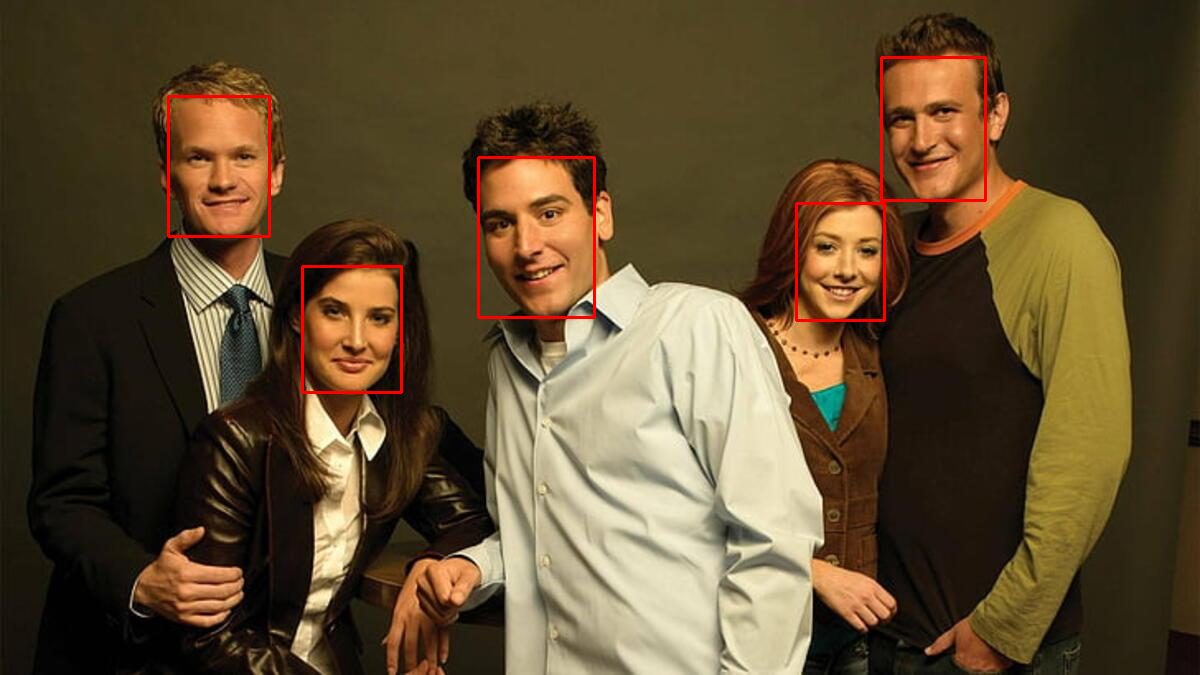

In [10]:
# OpenCV to PIL
res_img_plw = Image.fromarray(img_rgb)
res_img_plw